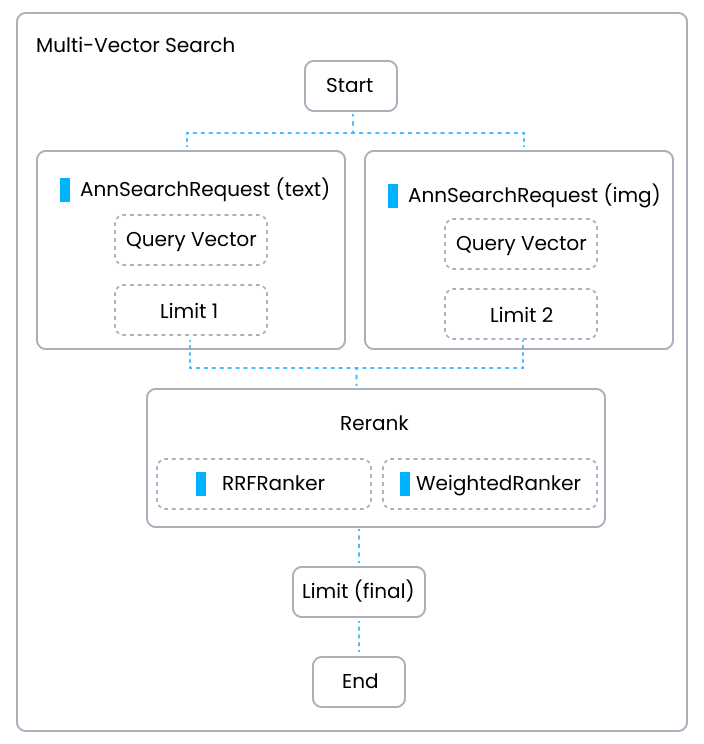

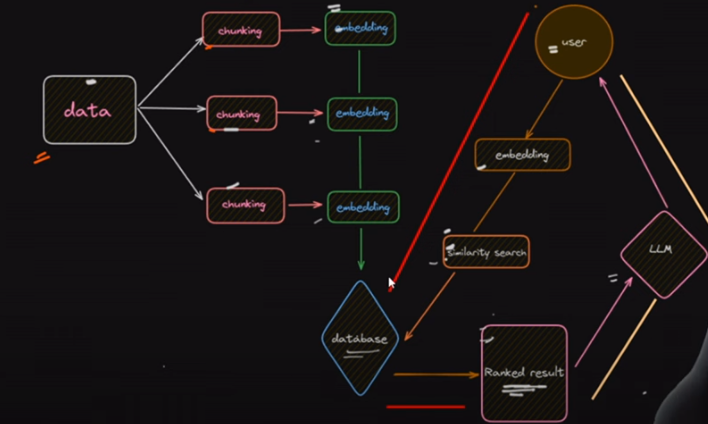

It is a 2 stage reteriva; 1.Retrieval 2.RRF - reranking 
https://medium.com/@sowmiyajaganathan/hybrid-search-with-re-ranking-ff120c8a426d

In [2]:

import textwrap
def wrap_text(text, width=90): #preserve_newlines
    # Split the input text into lines based on newline characters
    lines = text.split('\n')

    # Wrap each line individually
    wrapped_lines = [textwrap.fill(line, width=width) for line in lines]

    # Join the wrapped lines back together using newline characters
    wrapped_text = '\n'.join(wrapped_lines)

    return wrapped_text

In [4]:
import os


GOOGLE_API_KEY = ""
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY

In [ ]:

%pip install --upgrade --quiet  langchain-google-genai

In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI

In [ ]:
llm = ChatGoogleGenerativeAI(model="gemini-1.5-pro")
result = llm.invoke("Write a ballad about LangChain")
print(result.content)

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores.chroma import Chroma
import langchain

In [ ]:
from langchain.document_loaders import DirectoryLoader
from langchain.document_loaders import TextLoader
     

In [ ]:
!pip install unstrctured

In [ ]:
data_path = "data/UN SDG.pdf"

In [ ]:

loader = DirectoryLoader(data_path, glob="*.txt", show_progress=True)
docs = loader.load()

In [ ]:
len(docs)

In [ ]:
raw_text = ''
for i, doc in enumerate(docs):
    text = doc.page_content
    if text:
        raw_text += text

In [ ]:
print(raw_text)

In [ ]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 500,
    chunk_overlap  = 100,
    length_function = len,
    is_separator_regex = False,
)
     

texts = text_splitter.split_text(raw_text)

In [ ]:
from langchain.embeddings import HuggingFaceBgeEmbeddings
     

model_name = "BAAI/bge-small-en-v1.5"
encode_kwargs = {'normalize_embeddings': True}

In [ ]:
embedding_function = HuggingFaceBgeEmbeddings(
    model_name=model_name,
    #model_kwargs={'device': 'cuda'},
    encode_kwargs=encode_kwargs,
)

In [ ]:
db = Chroma.from_texts(texts,embedding_function,persist_directory="./chroma_db")
     

In [ ]:
query = "Tell me about Universal Studios Singapore?"

db.similarity_search(query, k=5)

In [ ]:

retriever = db.as_retriever() # can add mmr fetch_k=20, search_type="mmr"

retriever.get_relevant_documents(query)

# Chat chain

In [ ]:
from operator import itemgetter
from langchain.prompts import ChatPromptTemplate
from langchain.schema.output_parser import StrOutputParser
from langchain.schema.runnable import RunnableLambda, RunnablePassthrough

In [ ]:
template = """Answer the question based only on the following context:
{context}

Question: {question}
"""
     

prompt = ChatPromptTemplate.from_template(template)

In [ ]:
chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)
 

In [ ]:
text_reply = chain.invoke("Tell me about Universal Studio Singapore")

With RagFusion

In [ ]:
from langchain.schema.output_parser import StrOutputParser
from langchain.prompts import SystemMessagePromptTemplate, HumanMessagePromptTemplate
from langchain.prompts import ChatMessagePromptTemplate, PromptTemplate

In [ ]:
prompt = ChatPromptTemplate(input_variables=['original_query'],
                            messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[],template='You are a helpful assistant that generates multiple search queries based on a single input query.')),
                            HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['original_query'], template='Generate multiple search queries related to: {question} \n OUTPUT (4 queries):'))])
     


In [ ]:
original_query = "universal studios Singapore"

In [ ]:
generate_queries = (
    prompt | llm | StrOutputParser() | (lambda x: x.split("\n"))
)
     

generate_queries

In [ ]:
from langchain.load import dumps, loads



In [ ]:
def reciprocal_rank_fusion(results: list[list], k=60):
    fused_scores = {}
    for docs in results:
        # Assumes the docs are returned in sorted order of relevance
        for rank, doc in enumerate(docs):
            doc_str = dumps(doc)
            if doc_str not in fused_scores:
                fused_scores[doc_str] = 0
            previous_score = fused_scores[doc_str]
            fused_scores[doc_str] += 1 / (rank + k)

    reranked_results = [
        (loads(doc), score)
        for doc, score in sorted(fused_scores.items(), key=lambda x: x[1], reverse=True)
    ]
    return reranked_results
     

In [ ]:

ragfusion_chain = generate_queries | retriever.map() | reciprocal_rank_fusion

In [ ]:

langchain.debug = True

In [ ]:


ragfusion_chain.input_schema.schema()

In [ ]:

ragfusion_chain.invoke({"question": original_query})

In [ ]:
from langchain.schema.runnable import RunnablePassthrough
template = """Answer the question based only on the following context:
{context}

Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)

full_rag_fusion_chain = (
    {
        "context": ragfusion_chain,
        "question": RunnablePassthrough()
    }
    | prompt
    | llm
    | StrOutputParser()
)

In [ ]:

full_rag_fusion_chain.input_schema.schema()

In [ ]:
full_rag_fusion_chain.invoke({"question": "Tell me about Singapore’s nightlife scene?"})
     